In [2]:
# _%\

In [3]:
import pandas as pd

#Load and preprocess data
file_path = "../../../Data/DEngage Data/search_events/d8ad35dc-482c-41f8-8b0a-e7214fca773f.csv"
search_df = pd.read_csv(file_path)

#Unifying date formats
event_dates = list(search_df['event_date'])
new_event_dates = []
for date in event_dates:
    new_event_dates.append(date.replace("/","-")) #converts dates of (dd/mm/yyy) to (dd-mm-yyy)
search_df['event_date'] = new_event_dates

search_df['event_date'] = pd.to_datetime(search_df['event_date'], dayfirst=True) #Convert event_date column to datetime type

search_df['month'] = search_df['event_date'].dt.month #Add new column for month

search_df['keywords'] = search_df['keywords'].str.lower() #Make all strings in the 'keyword' column lowercase to avoid redundancy

search_df

,filters,key,session_id,event_date,keywords,result_count,month
0,NaN,2f1be8c3-48ed-4f24-85cd-2e4026e2e118,960863da-cd26-4cbb-8d71-fdabf5cbf378,2021-01-01 01:20:00,day old turkey,21,1
1,NaN,2f1be8c3-48ed-4f24-85cd-2e4026e2e118,960863da-cd26-4cbb-8d71-fdabf5cbf378,2021-01-01 01:38:00,day old turkey,21,1
2,NaN,2f1be8c3-48ed-4f24-85cd-2e4026e2e118,960863da-cd26-4cbb-8d71-fdabf5cbf378,2021-01-01 01:42:00,turkey,72,1
3,NaN,94be71ce-b2c3-4bc2-8c72-ac3f1972fee9,8200209d-894c-439e-be3a-91eb8c17f7bb,2021-01-01 01:47:00,NaN,932,1
4,NaN,57741bf7-7f64-42c4-ae0f-88a5d499bb54,03065ddb-da3a-453c-8a72-7f84d45bd078,2021-01-01 02:29:00,turkey,72,1
...,...,...,...,...,...,...,...
67188,NaN,a6a2c635-5eab-4662-ba6a-5b1a1fc96a5b,97e96612-b4c5-47db-beed-cdac3bdb5f34,2021-08-30 23:41:00,digital scale,39,8
67189,NaN,04dc0255-9a84-4902-be72-eb197c621877,c9b94273-f2af-4786-ae78-75aee611d686,2021-08-30 23:42:00,best pesticide,10,8
67190,NaN,04dc0255-9a84-4902-be72-eb197c621877,c9b94273-f2af-4786-ae78-75aee611d686,2021-08-30 23:49:00,best pesticide,10,8
67191,NaN,a6a2c635-5eab-4662-ba6a-5b1a1fc96a5b,97e96612-b4c5-47db-beed-cdac3bdb5f34,2021-08-30 23:58:00,tractor machine,4,8


### Total Syntatic Sort

In [4]:
#Find all unique keywords in the search events dataset
unique_keywords = list(search_df.keywords.unique())
print("There are '{}' unique keywords.".format(len(unique_keywords)))

#New dataframe to hold the aggregated result counts for each keyword
aggr_search_df = pd.DataFrame(columns=['keywords', 'total_result_count', 'avg_result_count'])

for kword in unique_keywords:
    if str(kword).lower() != 'nan':
        temp = search_df[search_df["keywords"] == kword]
        clean_temp = temp.drop_duplicates(subset=['key', 'session_id', 'result_count']) #identify duplicate data using the key, session id, and result count
        total_count = clean_temp.result_count.sum() #Sum up all result counts
        avg_count = total_count/len(clean_temp) #Find average result count
        aggr_search_df.loc[-1] = [kword, total_count, avg_count] #Add entry to the new dataframe
        aggr_search_df.index += 1
        
aggr_search_df = aggr_search_df.sort_index() #Sort index of datframe
aggr_search_df = aggr_search_df.sort_values('total_result_count', ascending=False) #Sort datframe by result_count in descending order
aggr_search_df.to_csv("aggr_search.csv")
aggr_search_df

There are '11874' unique keywords.


,keywords,total_result_count,avg_result_count
11754,feed,101632,379.223881
11862,broiler,41746,152.915751
11871,turkey,37468,79.213531
11483,scale,25499,100.389764
11452,chi,24882,592.428571
...,...,...,...
6963,sarosite,0,0.000000
6962,provider poultry,0,0.000000
2804,duckslings,0,0.000000
6958,triclycle,0,0.000000


#### Extra analysis on result - Checking Relationship between legth of keyword(or search phrase) and search results

In [5]:
#Load saved data
df = pd.read_csv("aggr_search.csv")

In [6]:
keyword_lens = [len(kword.split()) for kword in list(df.keywords)]
df["keyword_length"] = keyword_lens #add new column(keyword_length) to the dataframe

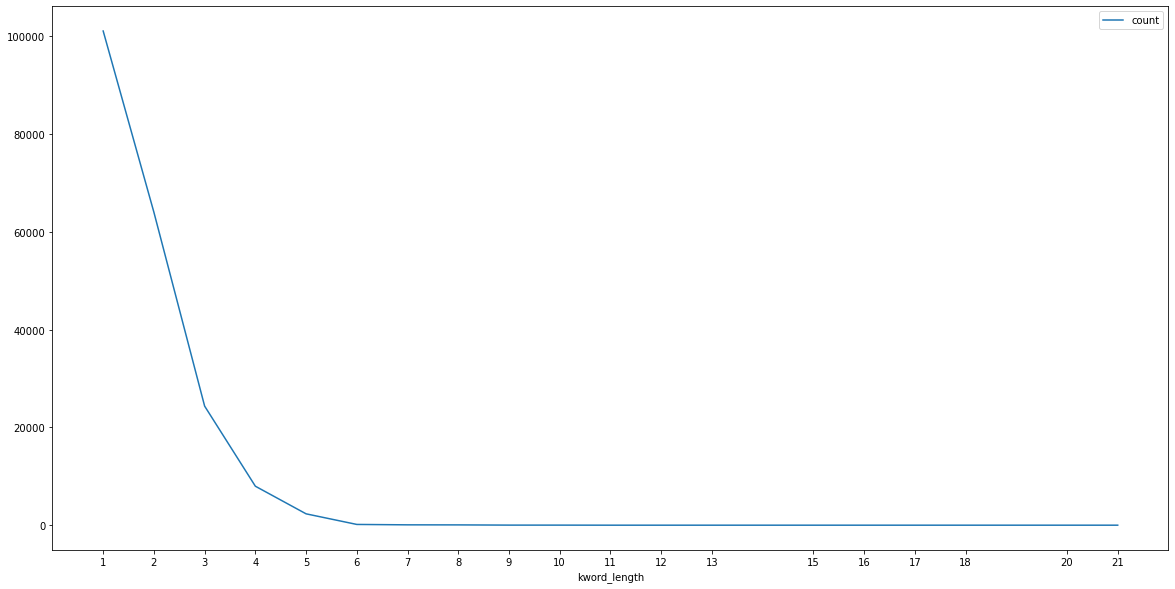

In [7]:
#Checking Relationship between legth of keyword(or search phrase) and search results
df = df.sort_values('keyword_length')

counts = []
for length in df.keyword_length.unique():
    temp_df = df[df["keyword_length"] == length]
    count = temp_df.avg_result_count.sum()
    counts.append(count)

#Create a dictionary of length of keywords and the accumulated search results for each one
len_count_dict = {"kword_length":df.keyword_length.unique(), "count":counts}
#Convert dictionary to a dataframe
len_count_df = pd.DataFrame(len_count_dict)

ticks = list(df.keyword_length.unique())
graph = len_count_df.plot.line(x="kword_length", y="count", figsize=(20,10), xticks=ticks)
graph

### Total Semantic Sort

In [8]:
import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

def convert_wordnet_tag(POS_tag):
    """Function to return the wordnet tag equivalent of pos tags that are adjectives or nouns"""
    wordnet_tags = []
    for tag in POS_tag:
        if tag[1].startswith('N'):
            wordnet_tags.append((tag[0], wordnet.NOUN))
        elif tag[1].startswith('J'):
            wordnet_tags.append((tag[0], wordnet.ADJ))
    return wordnet_tags

def lemmatize(lemmatizer, tags):
    """Lemmatizes a tagset tuple using its corresponding wordnet tag"""
    lemmatized = []
    for tagset in tags:
        lemmatized.append(lemmatizer.lemmatize(tagset[0], pos=tagset[1]))
    return lemmatized

def extract_tag(phrase, lemmatizer):
    """Function to tag a given phrase"""
    tokens = word_tokenize(phrase) #Tokenize phrase
    pos_tag = nltk.pos_tag(tokens) #Find the POS tag of each token
    tags = convert_wordnet_tag(pos_tag)
    lemmatized_tags = lemmatize(lemmatizer, tags)
    return sorted(lemmatized_tags)

In [9]:
#Tagging all keywords in the dataset

lemm = WordNetLemmatizer() #set instance of wordnet lemmatizer to be used

#load data
aggr_df = pd.read_csv("aggr_search.csv")

#get keywords from keywords column
keywords = list(aggr_df["keywords"])

all_tags = [] #Empty list to store tags

for kword in keywords[:]:
    tags = extract_tag(kword, lemm)
    all_tags.append(','.join(tags))
    
#add new column(tags) to assign tags to respective keywords
aggr_df['tags'] = all_tags
aggr_df

,Unnamed: 0,keywords,total_result_count,avg_result_count,tags
0,11754,feed,101632,379.223881,feed
1,11862,broiler,41746,152.915751,broiler
2,11871,turkey,37468,79.213531,turkey
3,11483,scale,25499,100.389764,scale
4,11452,chi,24882,592.428571,chi
...,...,...,...,...,...
11868,6963,sarosite,0,0.000000,sarosite
11869,6962,provider poultry,0,0.000000,"poultry,provider"
11870,2804,duckslings,0,0.000000,duckslings
11871,6958,triclycle,0,0.000000,triclycle


In [10]:
# Get unique tags from the new dataframe
unique_tags = aggr_df.tags.unique()

# New dataframe to store total semantic sort
semantic_df = pd.DataFrame(columns = ['keywords', 'tags', 'total_result_count'])

for tag in unique_tags:
    temp = aggr_df[aggr_df['tags'] == tag]
    keywords = "/".join(list(temp['keywords']))
    total_count = temp.total_result_count.sum() #Sum up all result counts
    semantic_df.loc[-1] = [keywords, tag, total_count] #Add entry to the new dataframe
    semantic_df.index += 1
        
semantic_df = semantic_df.sort_index() #Sort index of datframe
semantic_df = semantic_df.sort_values('total_result_count', ascending=False)
semantic_df.to_csv("total_semantic_sort.csv")
semantic_df

,keywords,tags,total_result_count
9688,feed/feeds/finisher feed/feed through/making f...,feed,114923
9687,broiler/broilers/broilers feed/broilers mash/b...,broiler,63778
9673,3 in 1/500/a/oven/pen/defeathering/seedling/ag...,,42957
9686,turkey/turkeys/turkey feed/imported turkey/abo...,turkey,42252
9681,day old broiler/day old broilers/broiler day o...,"broiler,day,old",31777
...,...,...,...
3230,hendrix startee,"hendrix,startee",0
3231,marshal broilers,"broiler,marshal",0
3232,ladies,lady,0
3233,organic poultry farming in india,"india,organic,poultry",0


### Total Monthly Semantic Search

In [6]:
#Seperating searches in original dataset into their respective months by date
month_dfs = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0} #List out all months
unique_months = list(search_df['event_date'].dt.month.unique()) #Get the months from the search_df

for mnth_name, month in zip(month_dfs.keys(), unique_months):
    month_dfs[mnth_name] = search_df[search_df['month'] == month]

month_dfs['Jan'].columns

Index(['filters', 'key', 'session_id', 'event_date', 'keywords',
       'result_count', 'month'],
      dtype='object')

In [13]:
# lemm = WordNetLemmatizer()

# for month in month_dfs.keys():
#     temp = month_dfs[month]
#     #Lemmatize all single keywords in the dataset
#     all_keys = temp['keywords'].tolist()
#     print(all_keys[:50])
#     lemm_keys = [lambda key: lemm.lemmatize(key, 'n') if len(str(key).split())==1
#                  else key
#                  for key in all_keys]
#     print(lemm_keys[:50])
#     #####################################################################################################
#     break

### Linking Searches with Pages Visited

In [51]:
#Load data
file_path_2 = "../../../Data/DEngage Data/page_view_event/913e9b97-a510-41ec-96e4-7a3ba13de494.csv"
page_events = pd.read_csv(file_path_2)

In [52]:
#Get all unique session ids in the search_events dataset
sess_ids = list(search_df.session_id.unique())

#new dataframe to hold results
search_page_link = pd.DataFrame(columns=["session_id", "searches", "pages_visited", "usefulness"]) #usefulness column still needs work!!!

for sess_id in sess_ids[3:9]:
    search_list = set(search_df[search_df["session_id"] == sess_id]["keywords"]) #get all unique searches for that session into a list
    pages_list = list(page_events[page_events["session_id"] == sess_id]["page_title"]) #get all pages visited in a particular session
    searches = ",".join(search_list)
    pages = ",".join(pages_list)
    search_page_link.loc[-1] = [sess_id, searches, pages.lower(), "useful"]
    search_page_link.index += 1

search_page_link.to_csv("search_vs_page_link.csv")
search_page_link

,session_id,searches,pages_visited,usefulness
5,17cd1c9d-f5d9-442a-9fb5-ae07e8bf179b,turkey,,useful
4,3c144dd5-b62a-48e6-8f4f-b514fab35c85,day old chicks,,useful
3,e084205e-a0d9-4d00-8a46-7e91e0335e3c,breedwell,broilers (day old chicks) | afrimash.com - nig...,useful
2,d13eb7ad-04c9-43a5-9f21-ae6bf3c3e7b0,"pig,whitefly","insecticides | afrimash.com - nigeria,perfect ...",useful
1,b4e78a2b-5137-4cd5-8953-f3b0eeabd0e0,battery,table eggs (small | medium) | afrimash.com - n...,useful
0,3135e319-c399-47f9-a6c6-143003072cb4,snail,"online shopping for poultry, fish, and more ag...",useful
